# Проект - Прогнозирование заказов такси (Временные ряды)

# Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

# Описание данных
- datetime
- num_orders (от англ. number of orders, «число заказов»).

## Подготовка

In [1]:
# загрузка необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option('max_columns', None) # показывать все столбцы df
pd.set_option('max_rows', None) # показывать все строки df
pd.options.display.float_format = '{:,.2f}'.format  # округление чисел до 2 знаков после точки

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV 

In [2]:
# загрузка данных
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('taxi.csv', index_col=['datetime'], parse_date=['datetime'])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
# вывод данных по df
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.isna().sum()

num_orders    0
dtype: int64

In [5]:
data.index.isna().sum()

0

In [6]:
data.index.duplicated().sum()

0

In [7]:
# проверка что даты идут в хронологическом порядке
data.index.is_monotonic

True

In [8]:
data.describe()

,num_orders
count,"26,496.00"
mean,14.07
std,9.21
min,0.00
25%,8.00
50%,13.00
75%,19.00
max,119.00


In [9]:
# сортировка по индексу (дате) и ресемплирование данных с интервалом в 1 час
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [10]:
data.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


**Выводы, информация п.1**
- данные загруженны, исследованы, сразу колонка datetime переведена в индексы
- пропусков, дубликатов - нет
- данные отсортированы по дате(индекс) по возрастанию
- df готов к анализу и обучению

## Анализ

In [11]:
data.index.is_monotonic

True

In [12]:
# исследуем Тренд, Сезонность 
# для этого сделаем ресемплирование на 1 день
data_day = data.resample('1D').sum()

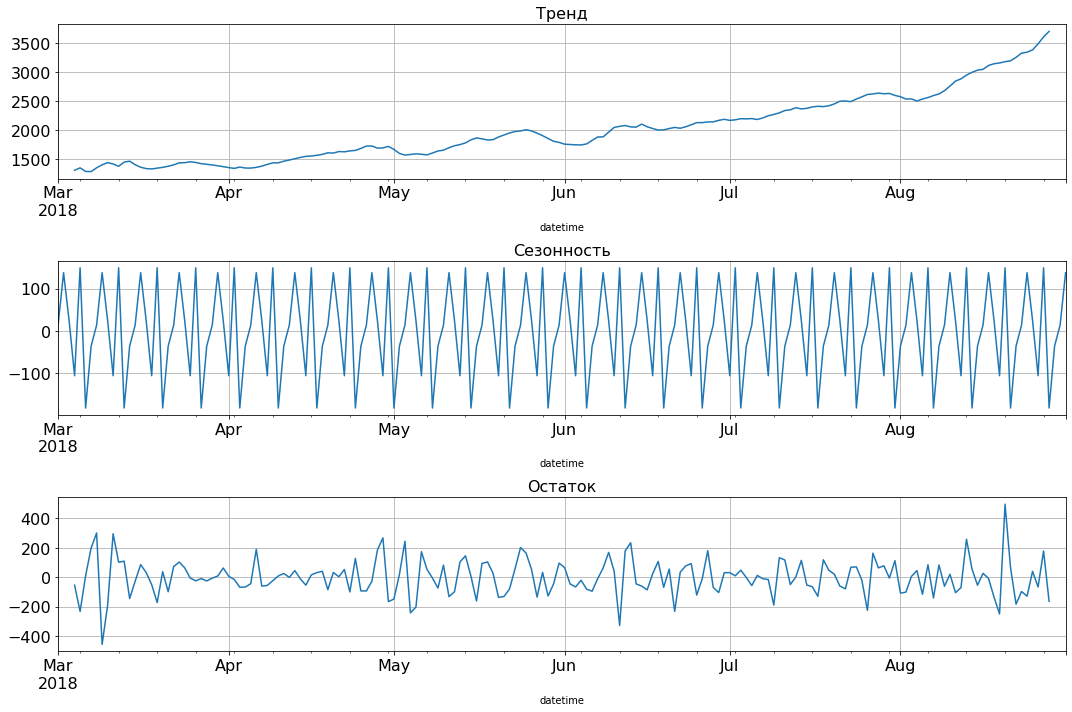

In [13]:
# построим графики для Тренда, Сезонности, Остатков
decomposed = seasonal_decompose(data_day)

plt.figure(figsize=(15,10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), grid=True, fontsize=16)
plt.title('Тренд', fontsize=16)
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), grid=True, fontsize=16)
plt.title('Сезонность', fontsize=16)
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), grid=True, fontsize=16)
plt.title('Остаток', fontsize=16)
plt.tight_layout()

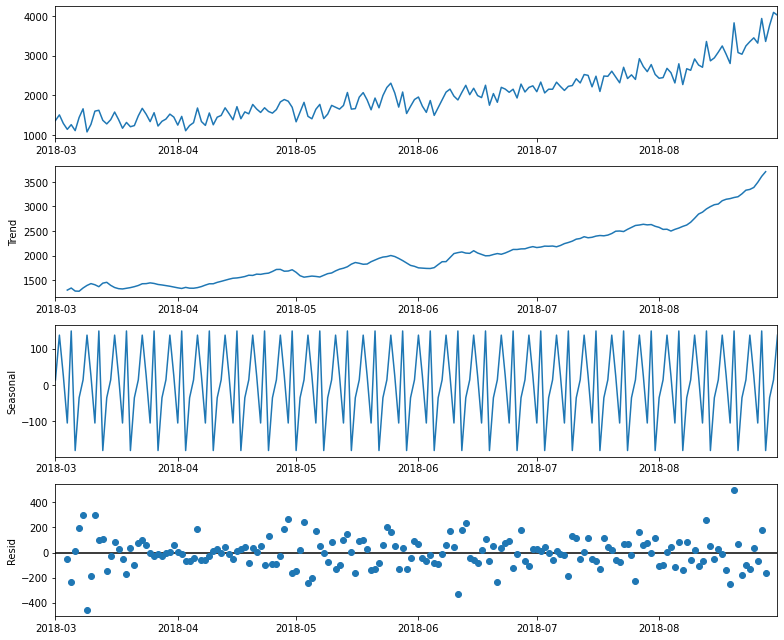

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9
decomposed.plot()
plt.show()

**комментарии**
из графиков выше:
- на всем периоде данных явно виден тренд на повышение заказов;
- сезонность, остатки из этих данных не понять: 
   - сезонность, если смотреть за год - то данных мало - меньше года;
   - ниже посмотрим динамику заказов в разрезе месяца/недели и дня

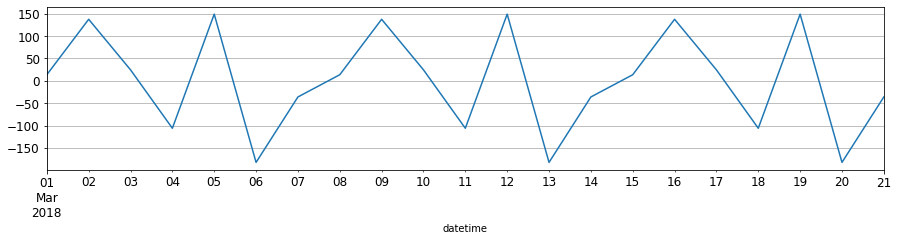

In [15]:
# график заказов за первые 21 день марта 2018 года
# 1.03.2018 - четверг
decomposed.seasonal['2018-03-01':'2018-03-21'].plot(figsize=(15,3), grid=True, fontsize=12);

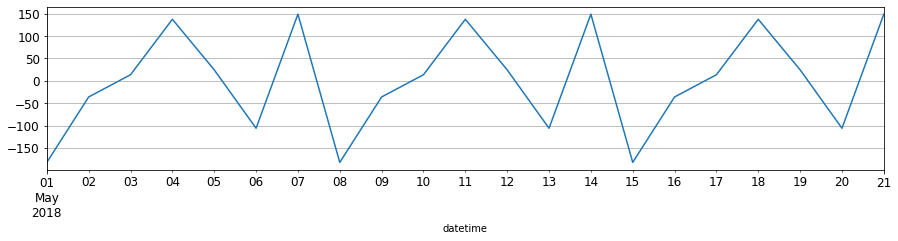

In [16]:
# график заказов за первые 21 день мая 2018 года
# 1.03.2018 - вторник
decomposed.seasonal['2018-05-01':'2018-05-21'].plot(figsize=(15,3), grid=True, fontsize=12);

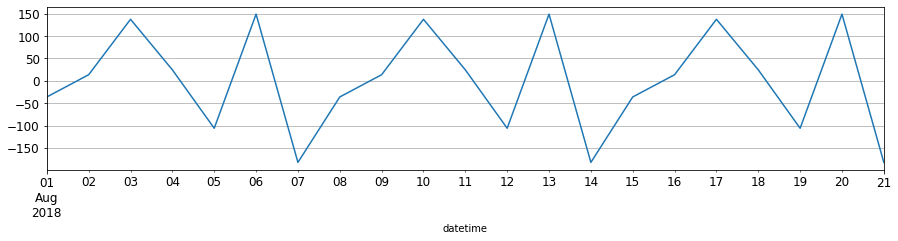

In [17]:
# график заказов за первые 21 день августа 2018 года
# 1.08.2018 - среда
decomposed.seasonal['2018-08-01':'2018-08-21'].plot(figsize=(15,3), grid=True, fontsize=12);

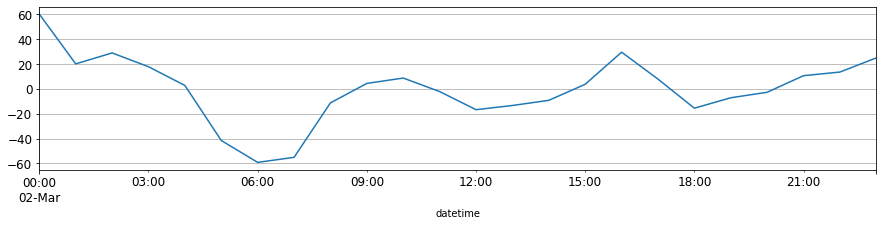

In [18]:
# график заказов 2 марта 2018 года
decomposed = seasonal_decompose(data)
decomposed.seasonal['2018-03-02':'2018-03-02'].plot(figsize=(15,3), grid=True, fontsize=12);

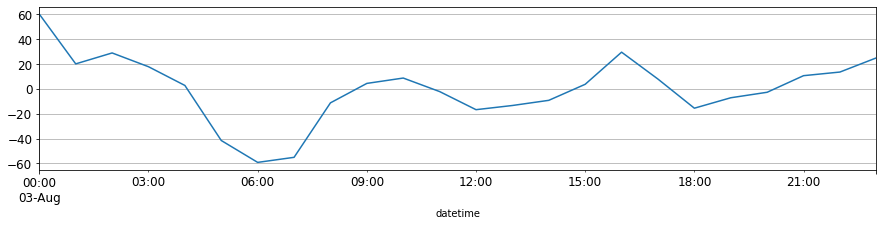

In [19]:
# график заказов 4 мая 2018 года
decomposed.seasonal['2018-08-03':'2018-08-03'].plot(figsize=(15,3), grid=True, fontsize=12);

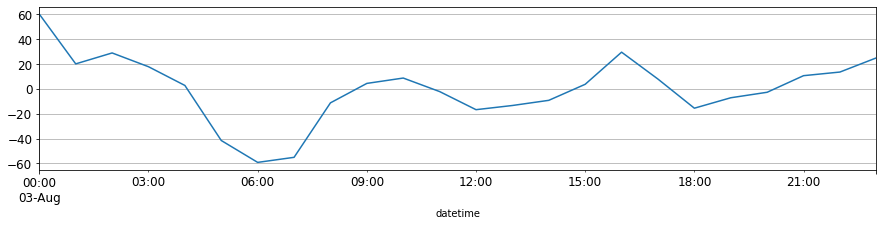

In [20]:
# график заказов 3 августа 2018 года
decomposed.seasonal['2018-08-03':'2018-08-03'].plot(figsize=(15,3), grid=True, fontsize=12);

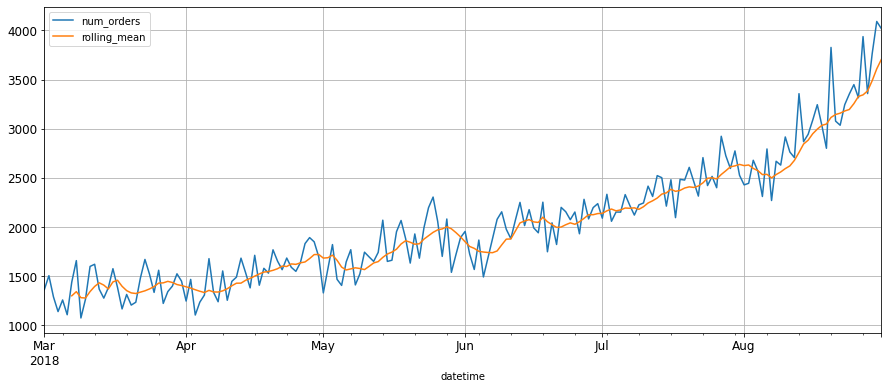

In [21]:
# построим скользящее среденее за весь период с семплированием в 1 неделю ?
data_day['rolling_mean'] = data_day.rolling(7).mean()
data_day.plot(figsize=(15,6), grid=True, fontsize=12);

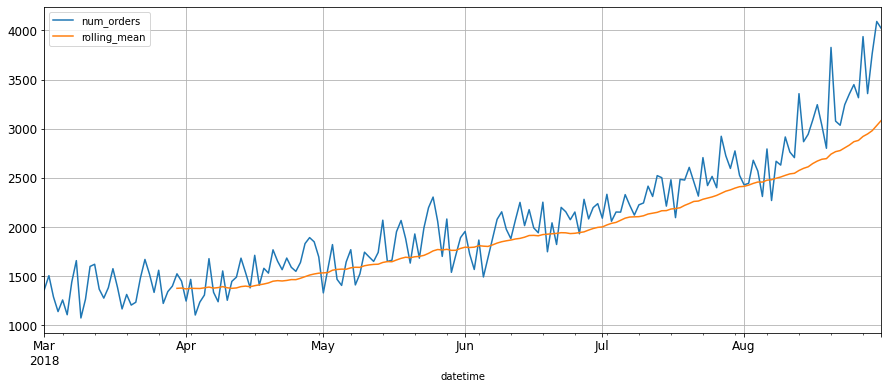

In [22]:
# построим скользящее среденее за весь период с семплированием в 1 месяц ?
data_day['rolling_mean'] = data_day.rolling(30).mean()
data_day.plot(figsize=(15,6), grid=True, fontsize=12);

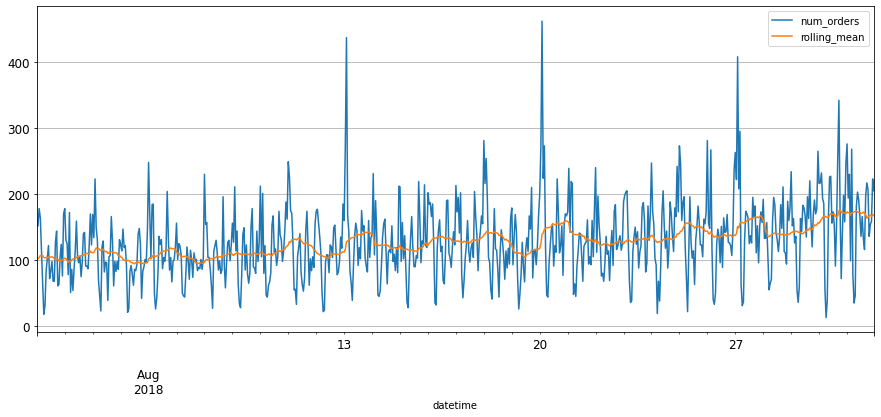

In [23]:
# построим скользящее среднее за два дня с семплированием в 1 час
data['rolling_mean'] = data.rolling(24).mean()
data['2018-08-02':'2018-08-31'].plot(figsize=(15,6), grid=True, fontsize=12);

**Выводы, информация п.2**

из ходя из графиков/ данных выше можно сказать следующие по динамике заказов:

- в течение дня: 
минимум заказов в 6.00, далее идет плавное повышение кол. заказов с локальными пиками в 9.00, 16.00, 24.00

- месяц/ неделя: минимум заказов  - воскресенье, вторник, максимум заказов - понедельник, пятница, средне количество заказов - среда, четверг, суббота

- на всем периоде данных явно виден тренд на повышение заказов: с 1500 в мае, до 3500 и выше в августе

- временной ряд не стационарный


Дополню:
есть изменения/ колебания в значениях временого ряда
- в течении недели
- в течении дня



## Обучение

In [24]:
data.head()

,num_orders,rolling_mean
datetime,,
2018-03-01 00:00:00,124,NaN
2018-03-01 01:00:00,85,NaN
2018-03-01 02:00:00,71,NaN
2018-03-01 03:00:00,66,NaN
2018-03-01 04:00:00,43,NaN


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   rolling_mean  4393 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 232.5 KB


In [26]:
# функция для формирования новых признаков
def make_features(data, max_lag, rolling_mean_size):
    #data['year'] = data.index.year
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()
    
    return data

### исследование  df с параметрами max_lag, rolling_mean_size равными 24
используемые модели:
- LinearRegression
- RandomForestRegressor с подбором гиперпараметров 

In [27]:
# вызов функции make_features с параметрами max_lag, rolling_mean_size равными 24 
data_24 = make_features(data, 24, 24)
data_24.head()

,num_orders,rolling_mean,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,1,124.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,3,2,85.00,124.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,3,3,71.00,85.00,124.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,3,4,66.00,71.00,85.00,124.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   rolling_mean  4392 non-null   float64
 2   dayofweek     4416 non-null   int64  
 3   hour          4416 non-null   int64  
 4   lag_1         4415 non-null   float64
 5   lag_2         4414 non-null   float64
 6   lag_3         4413 non-null   float64
 7   lag_4         4412 non-null   float64
 8   lag_5         4411 non-null   float64
 9   lag_6         4410 non-null   float64
 10  lag_7         4409 non-null   float64
 11  lag_8         4408 non-null   float64
 12  lag_9         4407 non-null   float64
 13  lag_10        4406 non-null   float64
 14  lag_11        4405 non-null   float64
 15  lag_12        4404 non-null   float64
 16  lag_13        4403 non-null   float64
 17  lag_14        4402 non-null

In [29]:
# удаление и проверка NaN значений
data_24 = data_24.dropna()
data_24.isna().sum().sum()

0

In [30]:
# разделение df на выборки на обучающую, валидационную и тестовую 
# с параметрами df max_lag, rolling_mean_size равными 24 

# разделим данные на выборки: признаки, целевой признак
features_24 = data_24.drop('num_orders', axis=1)
target_24 = data_24['num_orders']

# разделим на обучающую и тестовую выборки в пропорции 9 к 1
X_train_24, X_test_24, y_train_24, y_test_24 = train_test_split(features_24, target_24, 
                                                                    shuffle=False, test_size=0.1)

# разделим на обучающую и валидационную выборки в пропорции  4 к 1
X_train_24, X_valid_24, y_train_24, y_valid_24 = train_test_split(X_train_24, y_train_24, 
                                                                    shuffle=False, test_size=0.20)

# данные о размере выборок
print('размеры выборок на train: ', X_train_24.shape, y_train_24.shape) 
print('размеры выборок на valid: ', X_valid_24.shape, y_valid_24.shape) 
print('размеры выборок на test: ', X_test_24.shape, y_test_24.shape) 

размеры выборок на train:  (3161, 27) (3161,)
размеры выборок на valid:  (791, 27) (791,)
размеры выборок на test:  (440, 27) (440,)


#### LinearRegression с параметрами max_lag, rolling_mean_size равными 24 

In [31]:
# инициалиазция модели LinearRegression и обучение
model_LR_24 = LinearRegression()
model_LR_24.fit(X_train_24, y_train_24)

LinearRegression()

In [32]:
print("RMSE модель LinearRegression на валидационной выборке с параметрами df max_lag,\
rolling_mean_size равными 24:", 
round(mean_squared_error(y_valid_24, model_LR_24.predict(X_valid_24), squared=False),2))

RMSE модель LinearRegression на валидационной выборке с параметрами df max_lag,rolling_mean_size равными 24: 33.36


#### RandomForestRegressor  с параметрами max_lag, rolling_mean_size равными 24

In [33]:
# обучение модели на алгоритме RandomForestRegressor с изменением Гиперпараметров: 
# кол-во Деревьев и максимальная Глубина
best_model_RFR_24 = None
best_result_RFR_24 = 0
for est in range(10, 110, 10):
    for depth in range (1, 11):
        model_RFR_24 = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model_RFR_24.fit(X_train_24, y_train_24) 
        predict_RFR_24 = model_RFR_24.predict(X_valid_24) 
        result_RFR_24 = mean_squared_error(y_valid_24, predict_RFR_24, squared=False)
        if result_RFR_24 > best_result_RFR_24:
            best_model_RFR_24 = model_RFR_24
            best_result_RFR_24 = result_RFR_24
        
print("оценка RMSE лучшей модели_24 на валидационной выборке", round(best_result_RFR_24,2))
print('лучшая модель_24:', best_model_RFR_24,2)

оценка RMSE лучшей модели_24 на валидационной выборке 48.53
лучшая модель_24: RandomForestRegressor(max_depth=1, n_estimators=10, random_state=12345) 2


####  RMSE на валидационной выборке с параметрами df max_lag, rolling_mean_size равными 24:

- модель LinearRegression -  33.36

- модель RandomForestRegressor(max_depth=1, n_estimators=10) - 49.22



#### RMSE на тестовой выборке для  df с параметрами max_lag, rolling_mean_size равными 24:

###  исследование с параметрами max_lag, rolling_mean_size равными 168
используемые модели:
- LinearRegression
- RandomForestRegressor с подбором гиперпараметров

In [34]:
# вызов функции make_features с параметрами max_lag, rolling_mean_size равными 168
data_168 = make_features(data, 168, 168)
data_168 = data_168.dropna()
data_168.isna().sum().sum()

0

In [35]:
# разделение df на выборки на обучающую, валидационную и тестовую 
# с параметрами max_lag, rolling_mean_size равными 168

# разделим данные на выборки: признаки, целевой признак
features_168 = data_168.drop('num_orders', axis=1)
target_168 = data_168['num_orders']

# разделим на обучающую и тестовую выборки в пропорции 9 к 1
X_train_168, X_test_168, y_train_168, y_test_168 = train_test_split(features_168, target_168, 
                                                                    shuffle=False, test_size=0.1)

# разделим на обучающую и валидационную выборки в пропорции 4 к 1
X_train_168, X_valid_168, y_train_168, y_valid_168 = train_test_split(X_train_168, y_train_168, 
                                                                    shuffle=False, test_size=0.20)

# данные о размере выборок
print('размеры выборок на train: ', X_train_168.shape, y_train_168.shape) 
print('размеры выборок на valid: ', X_valid_168.shape, y_valid_168.shape) 
print('размеры выборок на test: ', X_test_168.shape, y_test_168.shape) 

размеры выборок на train:  (3058, 171) (3058,)
размеры выборок на valid:  (765, 171) (765,)
размеры выборок на test:  (425, 171) (425,)


In [36]:
# инициалиазция модели LinearRegression и обучение
model_LR_168 = LinearRegression()
model_LR_168.fit(X_train_168, y_train_168)

LinearRegression()

In [37]:
print("RMSE модель LinearRegression на валидационной выборке с параметрами max_lag,\
rolling_mean_size равными 168:", 
round(mean_squared_error(y_valid_168, model_LR_168.predict(X_valid_168), squared=False),2))

RMSE модель LinearRegression на валидационной выборке с параметрами max_lag,rolling_mean_size равными 168: 27.42


#### RandomForestRegressor  с параметрами max_lag, rolling_mean_size равными 168

In [38]:
# обучение модели на алгоритме RandomForestRegressor с изменением Гиперпараметров: 
# кол-во Деревьев и максимальная Глубина
best_model_RFR_168 = None
best_result_RFR_168 = 0
for est in range(10, 110, 10):
    for depth in range (1, 11):
        model_RFR_168 = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model_RFR_168.fit(X_train_168, y_train_168) 
        predict_RFR_168 = model_RFR_168.predict(X_valid_168) 
        result_RFR_168 = mean_squared_error(y_valid_168, predict_RFR_168, squared=False)
        if result_RFR_168 > best_result_RFR_168:
            best_model_RFR_168 = model_RFR_168
            best_result_RFR_168 = result_RFR_168
        
print("оценка RMSE лучшей модели_168 на валидационной выборке", round(best_result_RFR_168,2))
print('лучшая модель_168:', best_model_RFR_168,2)

оценка RMSE лучшей модели_168 на валидационной выборке 45.42
лучшая модель_168: RandomForestRegressor(max_depth=1, n_estimators=10, random_state=12345) 2


####  RMSE на валидационной выборке для df с параметрами  max_lag, rolling_mean_size равными 168:

- модель LinearRegression -  27.42

- модель RandomForestRegressor(max_depth=1, n_estimators=10) - 45.42

## Тестирование

In [39]:
# RMSE на тестовой выборке для df с параметрами max_lag, rolling_mean_size равными 24
print("RMSE LinearRegression на тестовой выборке для df с параметрами max_lag, \
rolling_mean_size равными 24 - ", 
      round(mean_squared_error(y_test_24, model_LR_24.predict(X_test_24), squared=False),2))

RMSE LinearRegression на тестовой выборке для df с параметрами max_lag, rolling_mean_size равными 24 -  46.39


In [40]:
# RMSE на тестовой выборке для df с параметрами max_lag, rolling_mean_size равными 168
print("RMSE LinearRegression на тестовой выборке для df с параметрами max_lag,\
rolling_mean_size равными 168 -", 
      round(mean_squared_error(y_test_168, model_LR_168.predict(X_test_168), squared=False),2))

RMSE LinearRegression на тестовой выборке для df с параметрами max_lag,rolling_mean_size равными 168 - 35.02


## Итоги, выводы, информация:

1. На основе этапа "Анализ Временого ряда" сформированны два df с параметрами max_lag, rolling_mean_size равными 24 и 168, как наиболее харатерные для большей сезоности в течение недели и часа для данных с семплированием в 1 час;

2. Для каждого df выборка разделена на обучающую, валидационную, тествую выборки;


3. Для обоих df использованы алгоритмы:
    - LinearRegression
    - RandomForestRegressor с подбором гиперпараметров 


4. Сделана оценка метрики RMSE на валидационной выборке и отобран лучшей алгоритм для даной задачи и данных;


5. Итог - лучший алгоритм для данной задачи и данных - LinearRegression с параметрами rolling_mean_size равными 168;


6. RMSE LinearRegression на тестовой выборке  - 35.02